In [1]:
!pip install kaggle


In [0]:
mkdir .kaggle

In [0]:
import json
token = {'username':'gouthamanasokan','key':'c028fa6982d0516ec12318c813a8ce1e'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d shayanfazeli/heartbeat -p /content


 95% 94.0M/98.8M [00:01<00:00, 52.3MB/s]
100% 98.8M/98.8M [00:01<00:00, 75.8MB/s]


In [8]:
#Importing the libraries
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

Using TensorFlow backend.


In [9]:
!unzip \*.zip

Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [0]:
df = pd.read_csv("mitbih_train.csv", header=None)
df2 = pd.read_csv("mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

In [0]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)


In [0]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

In [15]:
np.arange(0, 187)*8/1000

array([0.   , 0.008, 0.016, 0.024, 0.032, 0.04 , 0.048, 0.056, 0.064,
       0.072, 0.08 , 0.088, 0.096, 0.104, 0.112, 0.12 , 0.128, 0.136,
       0.144, 0.152, 0.16 , 0.168, 0.176, 0.184, 0.192, 0.2  , 0.208,
       0.216, 0.224, 0.232, 0.24 , 0.248, 0.256, 0.264, 0.272, 0.28 ,
       0.288, 0.296, 0.304, 0.312, 0.32 , 0.328, 0.336, 0.344, 0.352,
       0.36 , 0.368, 0.376, 0.384, 0.392, 0.4  , 0.408, 0.416, 0.424,
       0.432, 0.44 , 0.448, 0.456, 0.464, 0.472, 0.48 , 0.488, 0.496,
       0.504, 0.512, 0.52 , 0.528, 0.536, 0.544, 0.552, 0.56 , 0.568,
       0.576, 0.584, 0.592, 0.6  , 0.608, 0.616, 0.624, 0.632, 0.64 ,
       0.648, 0.656, 0.664, 0.672, 0.68 , 0.688, 0.696, 0.704, 0.712,
       0.72 , 0.728, 0.736, 0.744, 0.752, 0.76 , 0.768, 0.776, 0.784,
       0.792, 0.8  , 0.808, 0.816, 0.824, 0.832, 0.84 , 0.848, 0.856,
       0.864, 0.872, 0.88 , 0.888, 0.896, 0.904, 0.912, 0.92 , 0.928,
       0.936, 0.944, 0.952, 0.96 , 0.968, 0.976, 0.984, 0.992, 1.   ,
       1.008, 1.016,

In [16]:
X[C0]

array([[0.97794116, 0.92647058, 0.68137252, ..., 0.        , 0.        ,
        0.        ],
       [0.96011394, 0.86324787, 0.46153846, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.65945947, 0.18648648, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.99191374, 0.73584908, 0.21563342, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.83966243, 0.24050634, ..., 0.        , 0.        ,
        0.        ],
       [0.93478262, 0.73913044, 0.33540374, ..., 0.        , 0.        ,
        0.        ]])

In [17]:
X[C0][0]

array([0.97794116, 0.92647058, 0.68137252, 0.24509804, 0.15441176,
       0.19117647, 0.15196079, 0.08578432, 0.05882353, 0.04901961,
       0.04411765, 0.06127451, 0.06617647, 0.06127451, 0.04901961,
       0.07352941, 0.06127451, 0.06127451, 0.06617647, 0.06862745,
       0.09558824, 0.0759804 , 0.09313726, 0.10539216, 0.11519608,
       0.10294118, 0.11764706, 0.125     , 0.14215687, 0.12745099,
       0.15196079, 0.14460784, 0.16421568, 0.14460784, 0.15931372,
       0.15196079, 0.15441176, 0.14215687, 0.15196079, 0.15196079,
       0.14705883, 0.13235295, 0.12745099, 0.13480392, 0.13725491,
       0.1127451 , 0.10784314, 0.10539216, 0.10784314, 0.09803922,
       0.09313726, 0.10294118, 0.1004902 , 0.10539216, 0.10294118,
       0.11764706, 0.10539216, 0.12254902, 0.12745099, 0.14215687,
       0.14705883, 0.14460784, 0.1740196 , 0.23039216, 0.23774509,
       0.24754901, 0.23039216, 0.2254902 , 0.19852941, 0.17647059,
       0.13235295, 0.125     , 0.11764706, 0.12254902, 0.11274

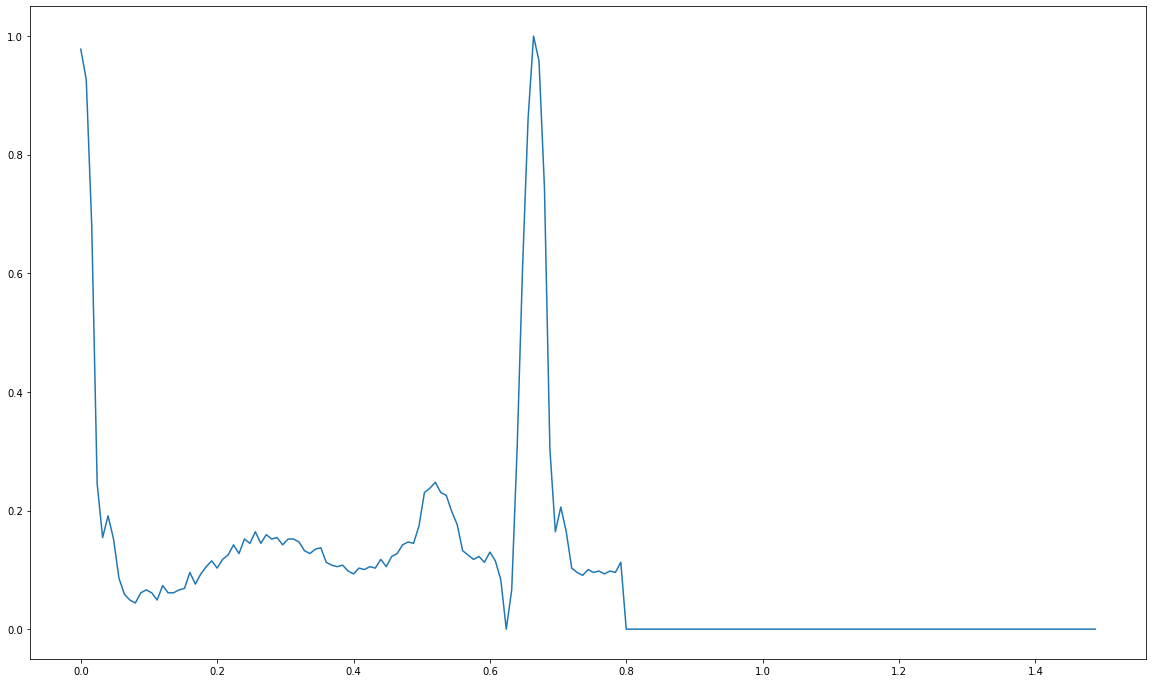

In [0]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")

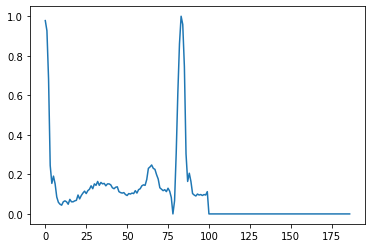

In [0]:
plt.plot(X[0, :])

In [0]:
l = int(187 * (1 + (random.random()-0.5)/3))
l

182

In [0]:
p=[1,2,3,4,5]

In [20]:
p

[1, 2, 3, 4, 5]

In [0]:
q=3

In [22]:
r = resample(p, q)
r

array([2.        , 2.30801829, 4.69198171])

In [0]:
X[0, :]

array([0.97794116, 0.92647058, 0.68137252, 0.24509804, 0.15441176,
       0.19117647, 0.15196079, 0.08578432, 0.05882353, 0.04901961,
       0.04411765, 0.06127451, 0.06617647, 0.06127451, 0.04901961,
       0.07352941, 0.06127451, 0.06127451, 0.06617647, 0.06862745,
       0.09558824, 0.0759804 , 0.09313726, 0.10539216, 0.11519608,
       0.10294118, 0.11764706, 0.125     , 0.14215687, 0.12745099,
       0.15196079, 0.14460784, 0.16421568, 0.14460784, 0.15931372,
       0.15196079, 0.15441176, 0.14215687, 0.15196079, 0.15196079,
       0.14705883, 0.13235295, 0.12745099, 0.13480392, 0.13725491,
       0.1127451 , 0.10784314, 0.10539216, 0.10784314, 0.09803922,
       0.09313726, 0.10294118, 0.1004902 , 0.10539216, 0.10294118,
       0.11764706, 0.10539216, 0.12254902, 0.12745099, 0.14215687,
       0.14705883, 0.14460784, 0.1740196 , 0.23039216, 0.23774509,
       0.24754901, 0.23039216, 0.2254902 , 0.19852941, 0.17647059,
       0.13235295, 0.125     , 0.11764706, 0.12254902, 0.11274

In [0]:
y = resample(X[0, :], l)
y

array([ 9.64765907e-01,  9.28852334e-01,  6.54829748e-01,  2.23067420e-01,
        1.59775603e-01,  1.89680226e-01,  1.41454319e-01,  7.58339078e-02,
        5.82116961e-02,  4.45958933e-02,  4.92502156e-02,  6.31462851e-02,
        6.73803071e-02,  5.37613442e-02,  5.70233125e-02,  7.43208591e-02,
        5.48573945e-02,  6.87594066e-02,  6.07659870e-02,  8.77167992e-02,
        8.51134485e-02,  8.19517347e-02,  1.02393722e-01,  1.13037466e-01,
        1.07064466e-01,  1.10844600e-01,  1.23553277e-01,  1.38713035e-01,
        1.31130540e-01,  1.44800921e-01,  1.48769734e-01,  1.58570859e-01,
        1.50923431e-01,  1.53194718e-01,  1.57271315e-01,  1.49907302e-01,
        1.46598012e-01,  1.48010111e-01,  1.55623480e-01,  1.42687336e-01,
        1.34544332e-01,  1.24550616e-01,  1.39648718e-01,  1.31006826e-01,
        1.12062736e-01,  1.05585946e-01,  1.07358898e-01,  1.05420647e-01,
        9.50696247e-02,  9.59795761e-02,  1.03308403e-01,  1.01608287e-01,
        1.04403581e-01,  

In [0]:
y_ = np.zeros(shape=(187, ))
y_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
y_[:l] = y
y_

array([ 9.64765907e-01,  9.28852334e-01,  6.54829748e-01,  2.23067420e-01,
        1.59775603e-01,  1.89680226e-01,  1.41454319e-01,  7.58339078e-02,
        5.82116961e-02,  4.45958933e-02,  4.92502156e-02,  6.31462851e-02,
        6.73803071e-02,  5.37613442e-02,  5.70233125e-02,  7.43208591e-02,
        5.48573945e-02,  6.87594066e-02,  6.07659870e-02,  8.77167992e-02,
        8.51134485e-02,  8.19517347e-02,  1.02393722e-01,  1.13037466e-01,
        1.07064466e-01,  1.10844600e-01,  1.23553277e-01,  1.38713035e-01,
        1.31130540e-01,  1.44800921e-01,  1.48769734e-01,  1.58570859e-01,
        1.50923431e-01,  1.53194718e-01,  1.57271315e-01,  1.49907302e-01,
        1.46598012e-01,  1.48010111e-01,  1.55623480e-01,  1.42687336e-01,
        1.34544332e-01,  1.24550616e-01,  1.39648718e-01,  1.31006826e-01,
        1.12062736e-01,  1.05585946e-01,  1.07358898e-01,  1.05420647e-01,
        9.50696247e-02,  9.59795761e-02,  1.03308403e-01,  1.01608287e-01,
        1.04403581e-01,  

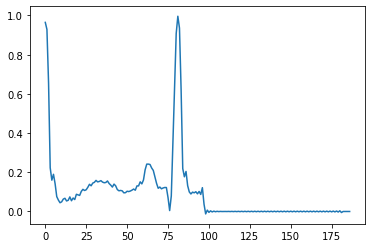

In [0]:
plt.plot(y_)

In [28]:
alpha = (random.random()-0.5)
alpha

0.49477348776015484

In [29]:
factor = -alpha*(0.5) + (1+alpha)
factor

1.2473867438800774

In [0]:
alpha = (random.random()-0.5)
alpha

0.40259012400100713

In [0]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

In [0]:
def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

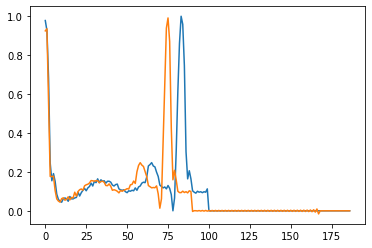

In [0]:
plt.plot(X[0, :])
plt.plot(stretch(X[0, :]))
plt.show()

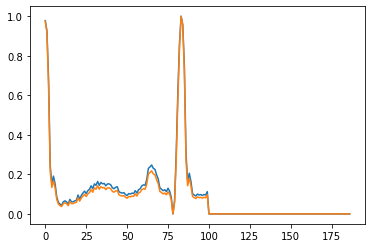

In [0]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.show()